# Testing changes

In [1]:
# Install required libraries
!pip install nibabel scikit-image

import logging
import os
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, label, binary_closing, binary_opening
from skimage.filters import threshold_otsu, gaussian

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# Create output directory
RESULTS_DIR = '/kaggle/working/results'
os.makedirs(RESULTS_DIR, exist_ok=True)
logging.info(f"Created output directory: {RESULTS_DIR}")

# Verify scikit-image version
import skimage
logging.info(f"scikit-image version: {skimage.__version__}")

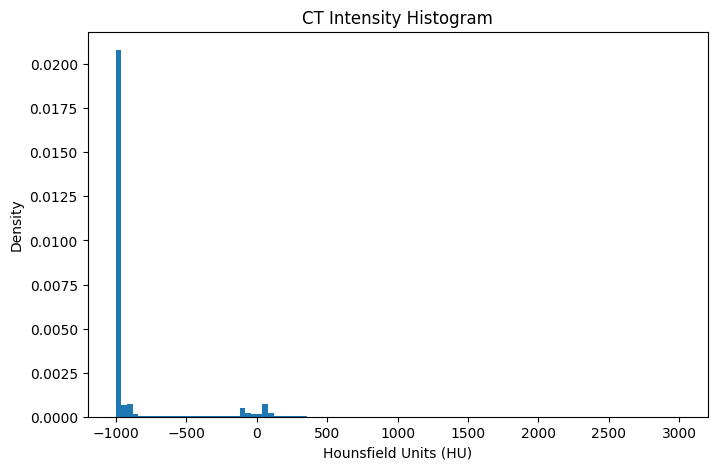

In [2]:
def analyze_ct_data(input_path: str = '/kaggle/input/ra-selection-1-data/3702_left_knee.nii') -> None:
    """
    Analyze the CT scan's properties and visualize its intensity distribution.

    Args:
        input_path (str): Path to the CT scan file.

    Raises:
        FileNotFoundError: If the input file is not found.
        RuntimeError: If loading the NIfTI file fails.
    """
    start_time = time.time()
    logging.info("Starting CT data analysis")

    try:
        # Check input file
        if not os.path.exists(input_path):
            error_msg = (
                f"CT scan not found at {input_path}. Verify with '!ls /kaggle/input/' and update path."
            )
            logging.error(error_msg)
            raise FileNotFoundError(error_msg)

        # Load CT scan
        ct_image = nib.load(input_path)
        ct_data = ct_image.get_fdata().astype(np.float32)
        header = ct_image.header

        # Log properties
        logging.info(f"CT shape: {ct_data.shape}")
        logging.info(f"Voxel sizes: {header.get_zooms()}")
        logging.info(f"Intensity range: {ct_data.min():.2f} to {ct_data.max():.2f} HU")

        # Visualize intensity histogram
        plt.figure(figsize=(8, 5))
        plt.hist(ct_data.ravel(), bins=100, range=(-1000, 3000), density=True)
        plt.title("CT Intensity Histogram")
        plt.xlabel("Hounsfield Units (HU)")
        plt.ylabel("Density")
        output_path = os.path.join(RESULTS_DIR, 'ct_histogram.png')
        plt.savefig(output_path)
        logging.info(f"Saved histogram: {output_path}")
        plt.show()

        logging.info(f"CT analysis completed in {time.time() - start_time:.2f} seconds")

    except Exception as e:
        logging.error(f"Failed to analyze CT: {e}")
        raise

# Analyze CT scan
INPUT_PATH = '/kaggle/input/ra-selection-1-data/3702_left_knee.nii'  # Update if needed
analyze_ct_data(INPUT_PATH)

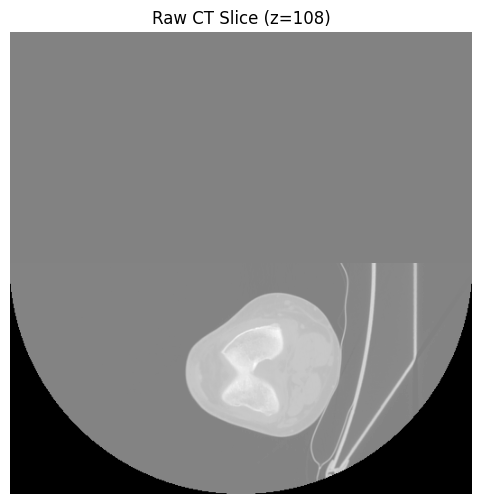

In [22]:
def load_ct(input_path: str = '/kaggle/input/ct-scan/ct_scan.nii.gz') -> tuple[np.ndarray, np.ndarray, nib.Nifti1Header]:
    """
    Load a 3D CT scan from the Kaggle input folder.

    Args:
        input_path (str): Path to the CT scan file.

    Returns:
        tuple: (CT data as numpy array, affine matrix, NIfTI header).

    Raises:
        FileNotFoundError: If the input file is not found.
        RuntimeError: If loading the NIfTI file fails.
    """
    start_time = time.time()
    logging.info(f"Loading CT from {input_path}")

    try:
        if not os.path.exists(input_path):
            error_msg = (
                f"CT scan not found at {input_path}. Verify with '!ls /kaggle/input/' and update path."
            )
            logging.error(error_msg)
            raise FileNotFoundError(error_msg)

        ct_image = nib.load(input_path)
        ct_data = ct_image.get_fdata().astype(np.float32)
        affine = ct_image.affine
        header = ct_image.header
        logging.info(f"CT shape: {ct_data.shape}, voxel sizes: {header.get_zooms()}")
        logging.info(f"Loading completed in {time.time() - start_time:.2f} seconds")

        # Visualize a sample slice
        slice_idx = ct_data.shape[2] // 2
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
        plt.title(f"Raw CT Slice (z={slice_idx})")
        plt.axis('off')
        output_path = os.path.join(RESULTS_DIR, 'raw_ct_slice.png')
        plt.savefig(output_path)
        logging.info(f"Saved raw CT slice: {output_path}")
        plt.show()

        return ct_data, affine, header

    except Exception as e:
        logging.error(f"Failed to load CT: {e}")
        raise

# Load CT scan
ct_data, affine, header = load_ct(INPUT_PATH)

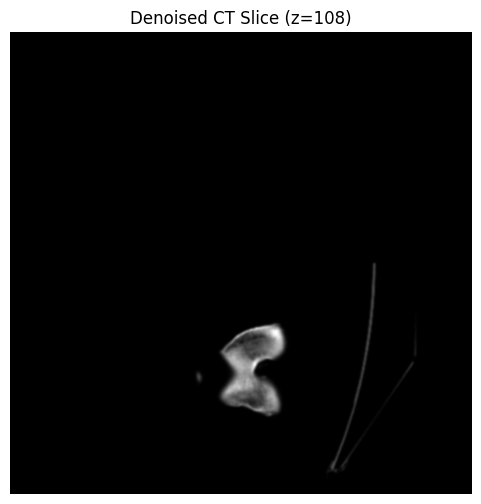

In [23]:
def preprocess_ct(ct_data: np.ndarray, sigma: float = 1.0) -> np.ndarray:
    """
    Preprocess CT data with Gaussian smoothing to reduce noise.

    Args:
        ct_data (np.ndarray): 3D CT volume.
        sigma (float): Standard deviation for Gaussian filter.

    Returns:
        np.ndarray: Preprocessed CT volume.

    Raises:
        ValueError: If ct_data is not 3D.
    """
    start_time = time.time()
    logging.info("Starting preprocessing")

    try:
        if ct_data.ndim != 3:
            raise ValueError("Expected 3D CT volume")

        ct_clipped = np.clip(ct_data, 100, 1500)
        ct_normalized = (ct_clipped - ct_clipped.min()) / (ct_clipped.max() - ct_clipped.min())
        ct_denoised = gaussian(ct_normalized, sigma=sigma, preserve_range=True)
        ct_processed = ct_denoised * (ct_clipped.max() - ct_clipped.min()) + ct_clipped.min()
        logging.info(f"Preprocessing completed in {time.time() - start_time:.2f} seconds")
        logging.info(f"Denoised intensity range: {ct_processed.min():.2f} to {ct_processed.max():.2f}")

        # Visualize denoised slice
        slice_idx = ct_data.shape[2] // 2
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_processed[:, :, slice_idx], cmap='gray')
        plt.title(f"Denoised CT Slice (z={slice_idx})")
        plt.axis('off')
        output_path = os.path.join(RESULTS_DIR, 'denoised_ct_slice.png')
        plt.savefig(output_path)
        logging.info(f"Saved denoised CT slice: {output_path}")
        plt.show()

        return ct_processed

    except Exception as e:
        logging.error(f"Preprocessing failed: {e}")
        raise

# Preprocess CT
ct_processed = preprocess_ct(ct_data)

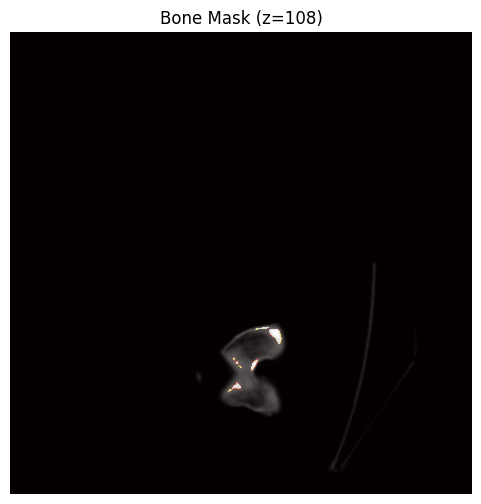

In [24]:
def threshold_bones(ct_data: np.ndarray) -> np.ndarray:
    """
    Apply Otsu's thresholding to isolate bone regions.

    Args:
        ct_data (np.ndarray): Preprocessed 3D CT volume.

    Returns:
        np.ndarray: Binary bone mask (uint8).

    Raises:
        ValueError: If ct_data is not 3D.
    """
    start_time = time.time()
    logging.info("Starting thresholding")

    try:
        if ct_data.ndim != 3:
            raise ValueError("Expected 3D CT volume")

        otsu_thresh = threshold_otsu(ct_data)
        bone_threshold = otsu_thresh * 0.9
        bone_mask = (ct_data > bone_threshold).astype(np.uint8)
        logging.info(f"Otsu threshold: {otsu_thresh:.2f}, adjusted: {bone_threshold:.2f}")
        logging.info(f"Thresholding completed in {time.time() - start_time:.2f} seconds")
        logging.info(f"Bone mask non-zero voxels: {np.sum(bone_mask)}")

        # Visualize bone mask
        slice_idx = ct_data.shape[2] // 2
        plt.figure(figsize=(6, 6))
        plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
        plt.imshow(bone_mask[:, :, slice_idx], cmap='hot', alpha=0.5)
        plt.title(f"Bone Mask (z={slice_idx})")
        plt.axis('off')
        output_path = os.path.join(RESULTS_DIR, 'bone_mask.png')
        plt.savefig(output_path)
        logging.info(f"Saved bone mask: {output_path}")
        plt.show()

        return bone_mask

    except Exception as e:
        logging.error(f"Thresholding failed: {e}")
        raise

# Threshold bones
bone_mask = threshold_bones(ct_processed)

In [14]:
def refine_mask(mask: np.ndarray, min_size: int = 1000) -> np.ndarray:
    """
    Refine binary mask with morphological operations and size filtering.

    Args:
        mask (np.ndarray): Binary mask to refine.
        min_size (int): Minimum component size to keep.

    Returns:
        np.ndarray: Refined mask (uint8).

    Raises:
        ValueError: If mask is not 3D.
    """
    if mask.ndim != 3:
        raise ValueError("Expected 3D mask")

    # Morphological operations
    struct = np.ones((3, 3, 3), dtype=np.uint8)
    mask = binary_closing(mask, structure=struct, iterations=2).astype(np.uint8)
    mask = binary_opening(mask, structure=struct, iterations=1).astype(np.uint8)

    # Remove small components
    labeled, num = label(mask)
    sizes = np.bincount(labeled.flat)[1:]
    mask = np.isin(labeled, np.where(sizes >= min_size)[0] + 1).astype(np.uint8)
    logging.info("Completed mask refinement")
    return mask

# Refine masks
femur_mask = refine_mask(femur_mask)
tibia_mask = refine_mask(tibia_mask)

In [15]:
def validate_anatomy(femur_mask: np.ndarray, tibia_mask: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Validate femur (superior) and tibia (inferior) labeling based on z-coordinates.

    Args:
        femur_mask (np.ndarray): Femur mask.
        tibia_mask (np.ndarray): Tibia mask.

    Returns:
        tuple: (Validated femur mask, validated tibia mask).

    Raises:
        ValueError: If masks are not 3D.
    """
    if femur_mask.ndim != 3 or tibia_mask.ndim != 3:
        raise ValueError("Expected 3D masks")

    # Compute z-coordinate centroids
    femur_z = np.mean(np.where(femur_mask)[2]) if np.any(femur_mask) else float('inf')
    tibia_z = np.mean(np.where(tibia_mask)[2]) if np.any(tibia_mask) else float('-inf')

    # Swap if femur is inferior
    if femur_z < tibia_z:
        logging.warning("Swapping femur and tibia labels")
        femur_mask, tibia_mask = tibia_mask, femur_mask

    return femur_mask, tibia_mask

# Validate anatomy
femur_mask, tibia_mask = validate_anatomy(femur_mask, tibia_mask)

In [16]:
def save_nifti(mask: np.ndarray, path: str, affine: np.ndarray, header: nib.Nifti1Header) -> None:
    """
    Save binary mask as a .nii.gz file.

    Args:
        mask (np.ndarray): Binary mask to save.
        path (str): Output file path.
        affine (np.ndarray): Affine matrix from original CT.
        header (nib.Nifti1Header): NIfTI header from original CT.

    Raises:
        RuntimeError: If saving fails.
    """
    try:
        nifti_img = nib.Nifti1Image(mask, affine, header)
        nib.save(nifti_img, path)
        logging.info(f"Saved mask: {path}")
    except Exception as e:
        logging.error(f"Failed to save mask: {e}")
        raise RuntimeError(f"Error saving mask to {path}")

# Save masks
save_nifti(femur_mask, os.path.join(RESULTS_DIR, 'femur_mask.nii.gz'), affine, header)
save_nifti(tibia_mask, os.path.join(RESULTS_DIR, 'tibia_mask.nii.gz'), affine, header)

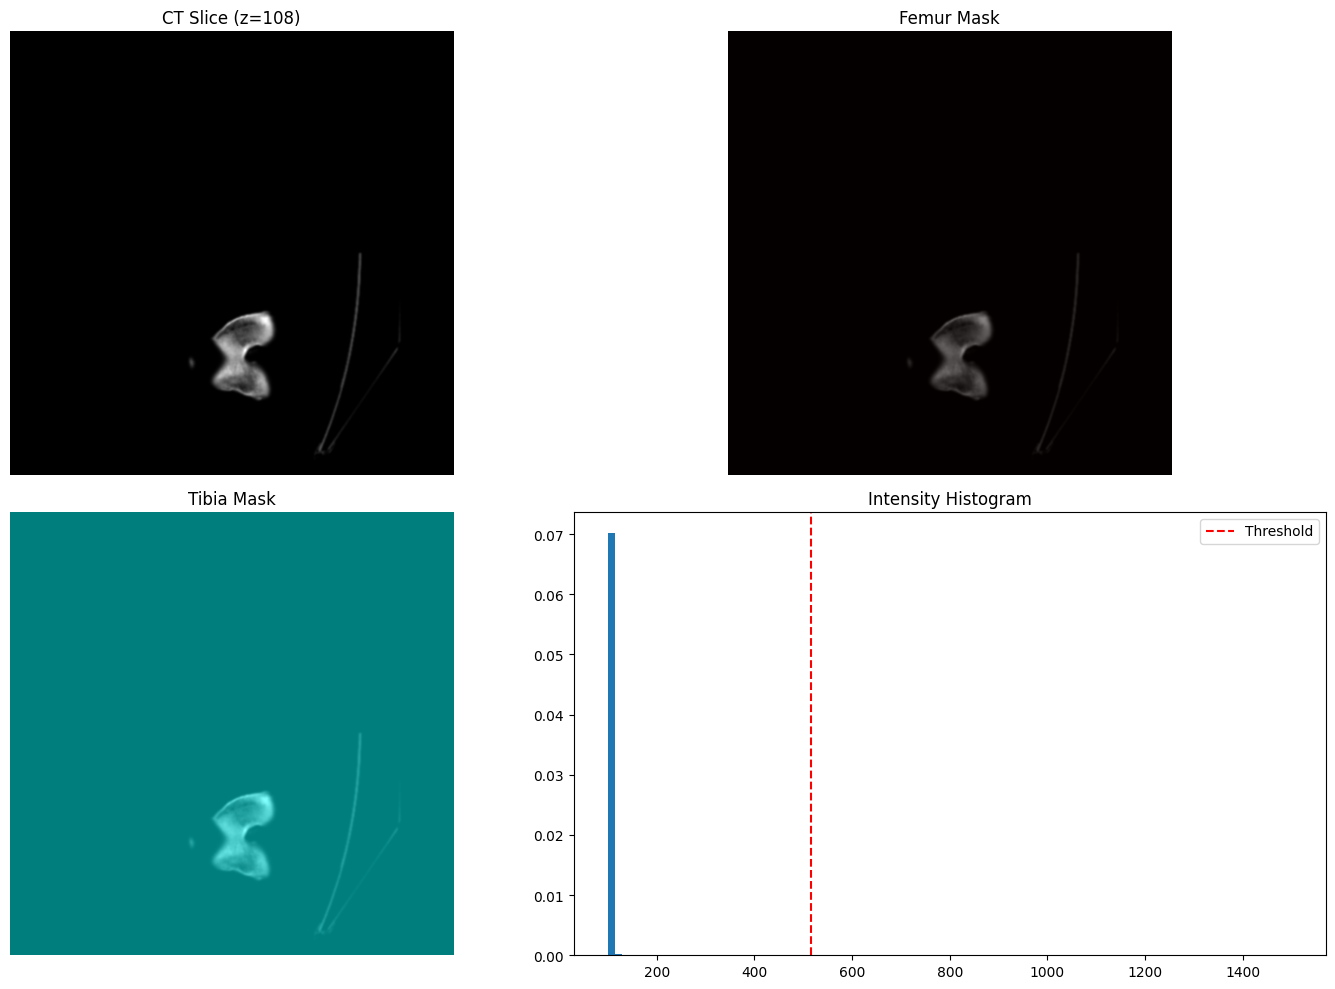

In [17]:
def visualize_results(ct_data: np.ndarray, femur_mask: np.ndarray, tibia_mask: np.ndarray, slice_idx: int = None) -> None:
    """
    Visualize CT slice, femur/tibia masks, and intensity histogram.

    Args:
        ct_data (np.ndarray): Preprocessed CT volume.
        femur_mask (np.ndarray): Femur mask.
        tibia_mask (np.ndarray): Tibia mask.
        slice_idx (int, optional): Z-slice index to visualize.

    Raises:
        ValueError: If inputs are not 3D or slice_idx is invalid.
    """
    if ct_data.ndim != 3 or femur_mask.ndim != 3 or tibia_mask.ndim != 3:
        raise ValueError("Expected 3D inputs")
    if slice_idx is None:
        slice_idx = ct_data.shape[2] // 2
    if not 0 <= slice_idx < ct_data.shape[2]:
        raise ValueError("Invalid slice index")

    # Create figure
    plt.figure(figsize=(15, 10))

    # CT slice
    plt.subplot(221)
    plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
    plt.title(f"CT Slice (z={slice_idx})")
    plt.axis('off')

    # Femur mask
    plt.subplot(222)
    plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
    plt.imshow(femur_mask[:, :, slice_idx], cmap='hot', alpha=0.5)
    plt.title("Femur Mask")
    plt.axis('off')

    # Tibia mask
    plt.subplot(223)
    plt.imshow(ct_data[:, :, slice_idx], cmap='gray')
    plt.imshow(tibia_mask[:, :, slice_idx], cmap='cool', alpha=0.5)
    plt.title("Tibia Mask")
    plt.axis('off')

    # Intensity histogram
    plt.subplot(224)
    plt.hist(ct_data.ravel(), bins=100, range=(100, 1500), density=True)
    plt.axvline(threshold_otsu(ct_data) * 0.9, color='r', linestyle='--', label='Threshold')
    plt.title("Intensity Histogram")
    plt.legend()

    # Save and show
    plt.tight_layout()
    output_path = os.path.join(RESULTS_DIR, 'segmentation_preview.png')
    plt.savefig(output_path)
    logging.info(f"Saved visualization: {output_path}")
    plt.show()

# Visualize results
visualize_results(ct_processed, femur_mask, tibia_mask)

In [18]:
def verify_outputs() -> None:
    """
    Verify that output files exist and masks are valid.

    Raises:
        FileNotFoundError: If output files are missing.
        ValueError: If masks overlap or are empty.
    """
    # Check file existence
    femur_path = os.path.join(RESULTS_DIR, 'femur_mask.nii.gz')
    tibia_path = os.path.join(RESULTS_DIR, 'tibia_mask.nii.gz')
    viz_path = os.path.join(RESULTS_DIR, 'segmentation_preview.png')
    for path in [femur_path, tibia_path, viz_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Output missing: {path}")

    # Check mask validity
    if np.sum(femur_mask & tibia_mask) > 0:
        raise ValueError("Femur and tibia masks overlap")
    if np.sum(femur_mask) < 1000 or np.sum(tibia_mask) < 1000:
        logging.warning("Masks may be too small; check segmentation")

    logging.info("Output verification passed")

# Verify outputs
verify_outputs()